# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
def build_model(audio_features, learning_rate=0.00005, num_classes=20):
    tf.keras.backend.clear_session()

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2], audio_features.shape[3]), name='Audio_Features')

    features = base_model(inputs)

    # Add a custom fully connected (dense) layer
    features = tf.keras.layers.Flatten()(features)

    features = tf.keras.layers.Dense(
        units=512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name='fc_1')(features)

    features = tf.keras.layers.Dropout(rate=0.3)(features)

    outputs = tf.keras.layers.Dense(
        units=num_classes,
        activation='softmax',
        name='fc_output')(features)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Birds_Transfer_Learning')

    print(model.summary())

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_VGG.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [17]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [18]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [19]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "Birds_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,114,068 (88.17 MB)

 Trainable params: 8,399,380 (32.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - accuracy: 0.3289 - loss: 10.1606 - val_accuracy: 0.5444 - val_loss: 5.4839
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5823 - loss: 4.7138 - val_accuracy: 0.5696 - val_loss: 3.4586
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.6520 - loss: 3.0271 - val_accuracy: 0.6185 - val_loss: 2.7224
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.7030 - loss: 2.3884 - val_accuracy: 0.6452 - val_loss: 2.3734
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.7413 - loss: 2.0714 - val_accuracy: 0.6459 - val_loss: 2.2303
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7633 - loss: 1.8793 - val_accuracy: 0.6659 - val_loss: 2.0427
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7729 - loss: 1.7398 - val_accuracy: 0.6348 - val_loss: 2.0020
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.

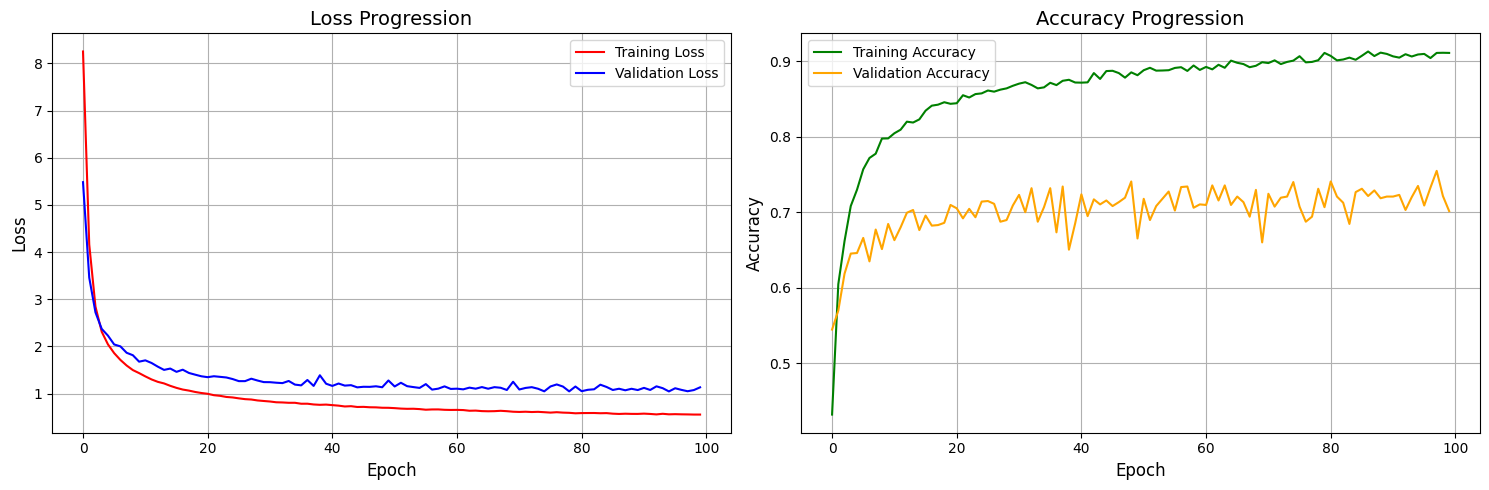

In [20]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [21]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9341 - loss: 0.4972
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7030 - loss: 1.1178


In [22]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       114
           1       0.41      0.77      0.53       141
           2       0.82      0.49      0.61       271
           3       0.99      0.84      0.91        90
           4       0.50      0.06      0.10        18
           5       0.62      0.53      0.57        15
           6       0.35      0.35      0.35        23
           7       0.93      0.98      0.96        44
           8       0.68      0.42      0.52        50
           9       0.79      0.98      0.87        49
          10       0.89      0.81      0.85        48
          11       0.81      0.65      0.72        46
          12       0.98      0.98      0.98        54
          13       0.45      0.88      0.59        48
          14       0.53      0.82      0.65        38
          15       0.84      0.56      0.67       117
          16       0.88      0.76      0.82   

### With Mel Spectrogram and MFCCs

In [26]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [27]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [28]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_output (Dense)                    │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,114,068 (88.17 MB)

 Trainable params: 8,399,380 (32.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.4315 - loss: 11.2830 - val_accuracy: 0.5985 - val_loss: 7.9018
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.7745 - loss: 6.7904 - val_accuracy: 0.6407 - val_loss: 6.4843
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8591 - loss: 5.4116 - val_accuracy: 0.6348 - val_loss: 5.7183
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.8904 - loss: 4.6528 - val_accuracy: 0.6489 - val_loss: 5.2564
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.9269 - loss: 4.0465 - val_accuracy: 0.6526 - val_loss: 4.7787
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9461 - loss: 3.5928 - val_accuracy: 0.6593 - val_loss: 4.4313
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9488 - loss: 3.2400 - val_accuracy: 0.6459 - val_loss: 4.2155
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9613 - l

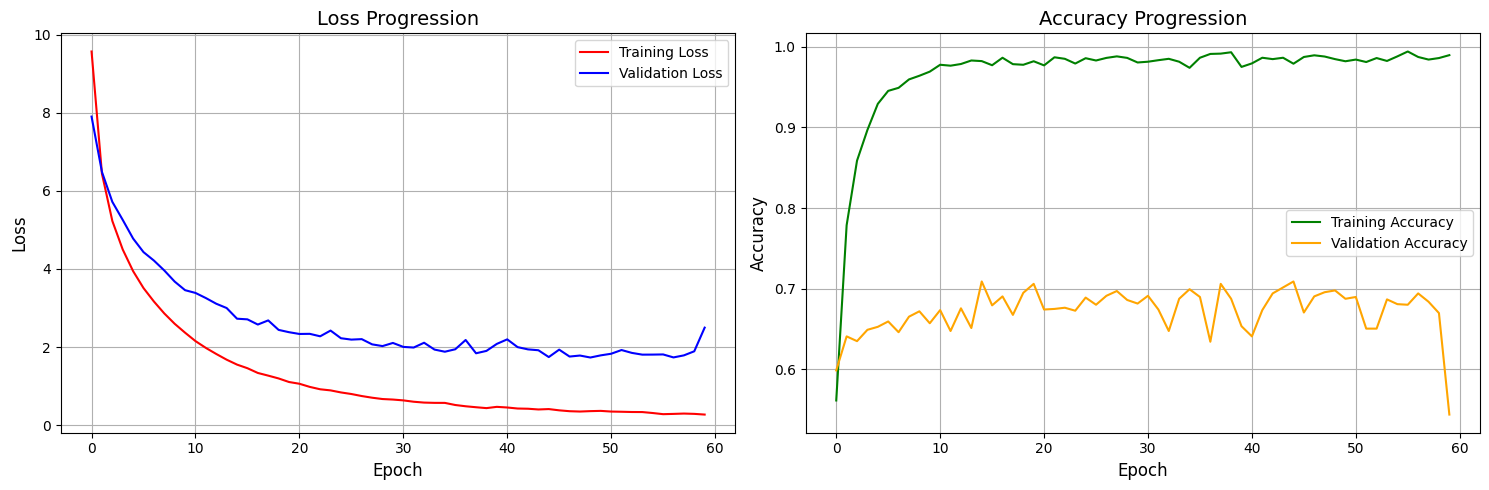

In [29]:
visualize(history, 'mfcc_melspectrogram')

In [30]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9558 - loss: 0.3452
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5378 - loss: 2.5237


In [31]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.62      0.46      0.53       114
           1       0.30      0.87      0.44       141
           2       0.91      0.18      0.30       271
           3       0.63      0.92      0.75        90
           4       0.00      0.00      0.00        18
           5       0.08      0.07      0.07        15
           6       0.42      0.61      0.50        23
           7       0.92      1.00      0.96        44
           8       0.52      0.34      0.41        50
           9       0.95      0.71      0.81        49
          10       0.66      0.73      0.69        48
          11       0.41      0.54      0.47        46
          12       0.90      0.98      0.94        54
          13       0.15      0.25      0.19        48
          14       0.28      0.13      0.18        38
          15       0.65      0.47      0.54       117
          16       0.92      0.98      0.95   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Review all the results

In [32]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,melspectrogram_chroma_mfcc,0.930,0.701
1,mfcc_melspectrogram,0.956,0.544


In [33]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0  melspectrogram_chroma_mfcc     0.703      0.970
1         mfcc_melspectrogram     0.529      0.937
